# Анализ лояльности пользователей Яндекс Афиши

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [1]:
!pip install sqlalchemy 
!pip install phik
!pip install python-dotenv

In [3]:
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt
import phik
import os
from dotenv import load_dotenv

In [4]:
user = os.getenv("USER")
pwd = os.getenv("PWD")
host = os.getenv("HOST")
port = os.getenv("PORT")
db = os.getenv("DB")

In [3]:
db_config = {'user': user, # имя пользователя
             'pwd': pwd, # пароль
             'host': host,
             'port': port, # порт подключения
             'db': db # название базы данных
             } 

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
) 

engine = create_engine(connection_string) 

query = '''
WITH with_days_since_prev AS (
  SELECT 
    p.user_id,
    p.device_type_canonical,
    p.order_id,
    p.created_dt_msk AS order_dt,
    p.created_ts_msk AS order_ts,
    p.currency_code,
    p.revenue,
    p.tickets_count,
    p.created_dt_msk::date - 
    LAG(p.created_dt_msk::date) OVER (
        PARTITION BY p.user_id 
        ORDER BY p.created_dt_msk
    ) AS days_since_prev,
    p.event_id,
    e.event_name_code AS event_name,
    e.event_type_main,
    p.service_name,
    r.region_name,
    c.city_name
  FROM 
      afisha.purchases p
      INNER JOIN afisha.events e ON e.event_id = p.event_id
      INNER JOIN afisha.city c ON c.city_id = e.city_id
      INNER JOIN afisha.regions r ON r.region_id = c.region_id
  WHERE (p.device_type_canonical IN ('mobile', 'desktop') AND e.event_type_main != 'фильм')
)

SELECT
  *
FROM with_days_since_prev
ORDER BY user_id ASC
'''

df = pd.read_sql_query(query, con=engine) 

In [4]:
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк


---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

In [6]:
df.describe()

,order_id,revenue,tickets_count,days_since_prev,event_id
count,2.906110e+05,290611.000000,290611.000000,268678.000000,290611.000000
mean,4.326225e+06,625.584360,2.754311,3.222381,438019.834992
std,2.497551e+06,1227.693064,1.170620,11.350509,147423.078841
min,1.000000e+00,-90.760000,1.000000,0.000000,4436.000000
25%,2.163618e+06,116.850000,2.000000,0.000000,361772.000000
50%,4.326366e+06,356.010000,3.000000,0.000000,498275.000000
75%,6.488330e+06,810.130000,4.000000,1.000000,546287.000000
max,8.653108e+06,81174.540000,57.000000,148.000000,592325.000000


Промежуточный вывод:
  * Был выгружен датафрейм с данными о покупках на сервисе Яндекс Афиша
  * Данные представлены таблицей из 15 столбцов в которой 290 611 записей
  * В столбце days_since_prev наблюдается 21 933 пропуска (~7,5% от общего количества записей)
  * Проблем с типами данных нет, но для улучшения производительности можно снизить тип данных с int64 до int8
    в столбце tickets_count
  * Названия столбцов уже приведены к snake case
  * Столбцы service_name, region_name и city_name желательно привести к нижнему регистру чтобы избежать возможных задвоений

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [7]:
currency_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')
currency_df.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [8]:
currency_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


In [9]:
# Преобразуем столбец data в datetime
currency_df['data'] = pd.to_datetime(currency_df['data'])

In [10]:
# Временно объединяем датафреймы
df = pd.merge(df, currency_df, left_on='order_dt', right_on='data', how='left')

In [11]:
def kzt_to_rub(row):
    """ Перевод из тенге в рубли """
    if row['currency_code'] == 'kzt':
        return row['revenue'] / row['nominal'] * row['curs']
    else:
        return row['revenue']
    
df['revenue_rub'] = df.apply(kzt_to_rub, axis=1)
df = df.drop(columns=currency_df.columns)

In [12]:
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск,1521.94
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск,289.45
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск,1258.57
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск,8.49
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк,1390.41


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [14]:
df['tickets_count'] = pd.to_numeric(df['tickets_count'], downcast='integer')
df['revenue'] = pd.to_numeric(df['revenue'], downcast='integer')
df['device_type_canonical'] = df['device_type_canonical'].str.lower()
df['event_type_main'] = df['event_type_main'].str.lower()
df['service_name'] = df['service_name'].str.lower()
df['region_name'] = df['region_name'].str.lower()
df['city_name'] = df['city_name'].str.lower()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int8          
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

In [15]:
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,край билетов,каменевский регион,глиногорск,1521.94
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,мой билет,каменевский регион,глиногорск,289.45
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,за билетом!,каменевский регион,глиногорск,1258.57
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,лови билет!,североярская область,озёрск,8.49
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,билеты без проблем,озернинский край,родниковецк,1390.41


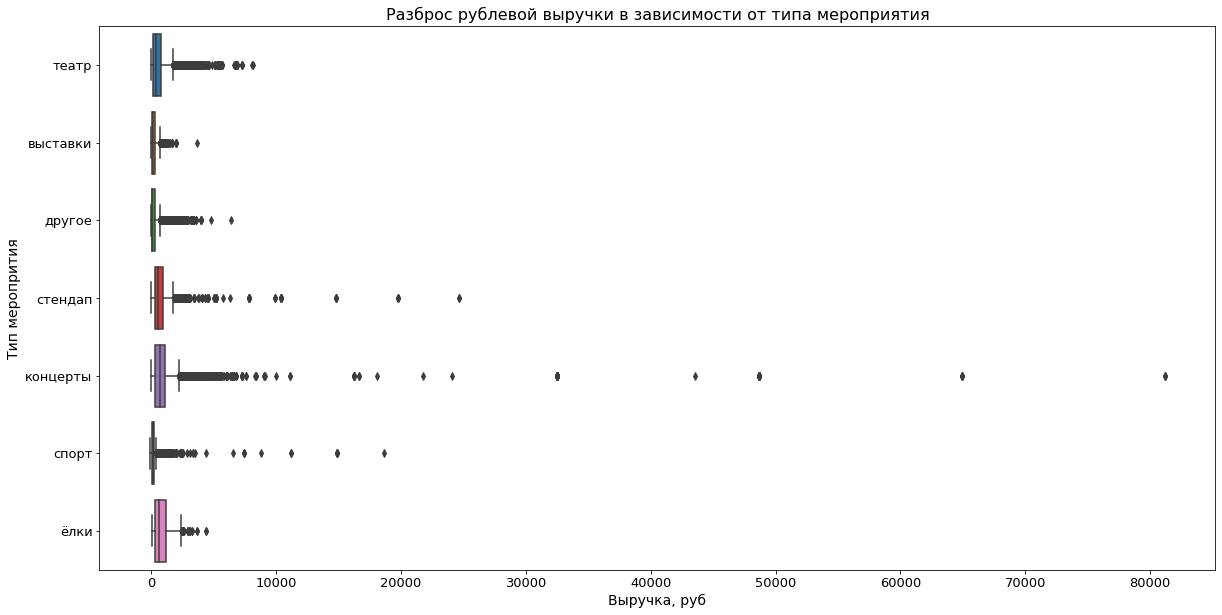

In [16]:
plt.figure(figsize=(20 ,10))
sns.boxplot(data=df, x='revenue_rub', y='event_type_main')

plt.xlabel('Выручка, руб', fontsize=14)
plt.ylabel('Тип меропрития', fontsize=14)
plt.title('Разброс рублевой выручки в зависимости от типа мероприятия', fontsize=16)
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)
plt.show()

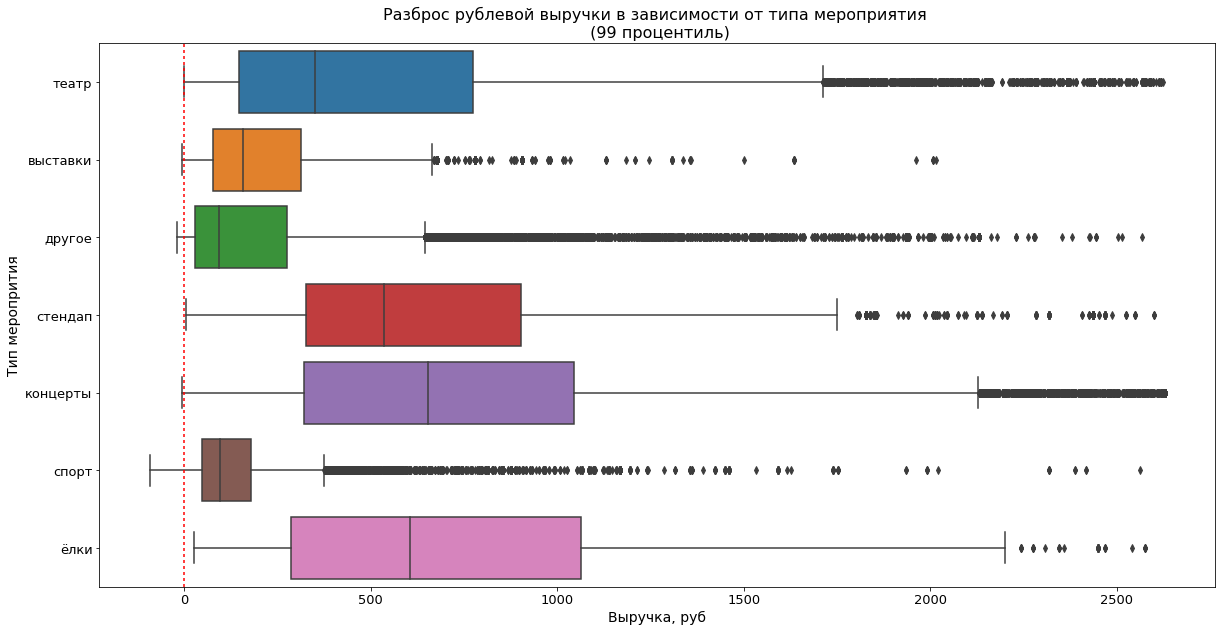

In [17]:
percentile_99 = df['revenue_rub'].quantile(0.99)
df_filtered = df[df['revenue_rub'] <= percentile_99]

plt.figure(figsize=(20 ,10))
sns.boxplot(data=df_filtered, x='revenue_rub', y='event_type_main')

plt.axvline(0, color='r', dashes=(2, 2))
plt.xlabel('Выручка, руб', fontsize=14)
plt.ylabel('Тип меропрития', fontsize=14)
plt.title('Разброс рублевой выручки в зависимости от типа мероприятия \n (99 процентиль)', fontsize=16)
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)
plt.show()

In [18]:
# убираем строки с выручкой <= 0
pos_rev_df = df_filtered.copy()
pos_rev_df = pos_rev_df[pos_rev_df['revenue_rub']>0]
print(f"Количество удаленных строк: {df.shape[0] - pos_rev_df.shape[0]}")
print(f"Доля удаленных строк от начального датафрейма: {((df.shape[0] - pos_rev_df.shape[0]) / df.shape[0]) * 100:.2f}%")

Количество удаленных строк: 8732
Доля удаленных строк от начального датафрейма: 3.00%


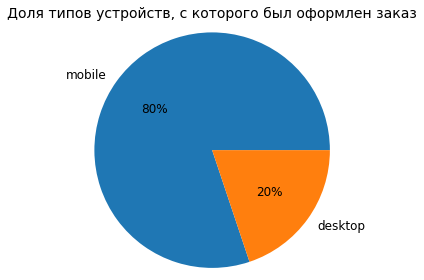

In [19]:
device_type_df = pos_rev_df['device_type_canonical'].value_counts().reset_index()

fig, ax = plt.subplots()
ax.pie(device_type_df['device_type_canonical'],
       labels=device_type_df['index'],
       radius=1.2,
       autopct='%.0f%%',
       textprops=dict(color='black', fontsize=12))

ax.set_title('Доля типов устройств, с которого был оформлен заказ',
            fontsize=14, pad=10)
plt.tight_layout()
plt.show()

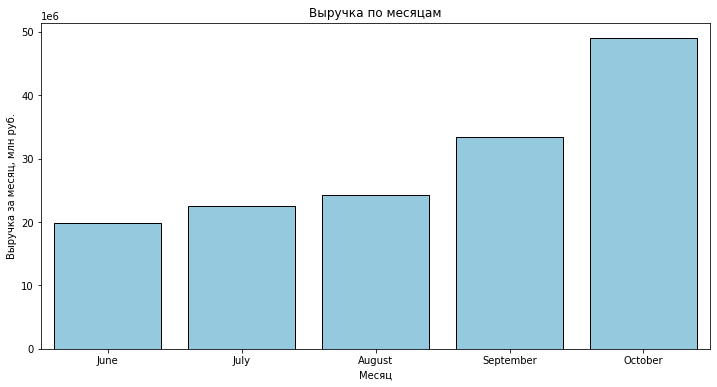

In [20]:
monthly_revenue = pos_rev_df.groupby(pos_rev_df['order_dt'].dt.to_period('M'))['revenue_rub'].sum().reset_index()
monthly_revenue['month_name'] = monthly_revenue['order_dt'].dt.strftime('%B')

plt.figure(figsize=(12, 6))

sns.barplot(data=monthly_revenue, 
            x='month_name', 
            y='revenue_rub',
            color='skyblue',
            edgecolor='black')

plt.ticklabel_format(axis='y', scilimits=(6,6))
plt.title('Выручка по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Выручка за месяц, млн руб.')
plt.show()

In [21]:
# Новый столбец для выручки на один билет
pos_rev_df.loc[:, 'rev_per_ticket'] = pos_rev_df['revenue_rub'] / pos_rev_df['tickets_count']

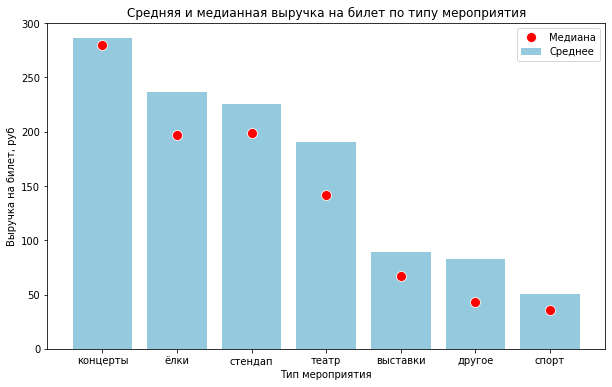

In [22]:
grouped_by_event_type = pos_rev_df.groupby(by='event_type_main').mean().reset_index()

median_values = pos_rev_df.groupby(by='event_type_main')['rev_per_ticket'].median().reset_index()
median_values.columns = ['event_type_main', 'median_rev']

grouped_by_event_type = grouped_by_event_type.merge(median_values, on='event_type_main')
grouped_by_event_type = grouped_by_event_type.sort_values(by='rev_per_ticket', ascending=False)

plt.figure(figsize=(10, 6))

ax = sns.barplot(data=grouped_by_event_type,
            x='event_type_main',
            y='rev_per_ticket',
            color='skyblue',
            label='Среднее')

sns.scatterplot(data=grouped_by_event_type,
               x='event_type_main',
               y='median_rev',
               color='red',
               s=100,
               marker='o',
               label='Медиана',
               zorder=5)

plt.title('Средняя и медианная выручка на билет по типу мероприятия')
plt.xlabel('Тип мероприятия')
plt.ylabel('Выручка на билет, руб')
plt.legend()
plt.show()

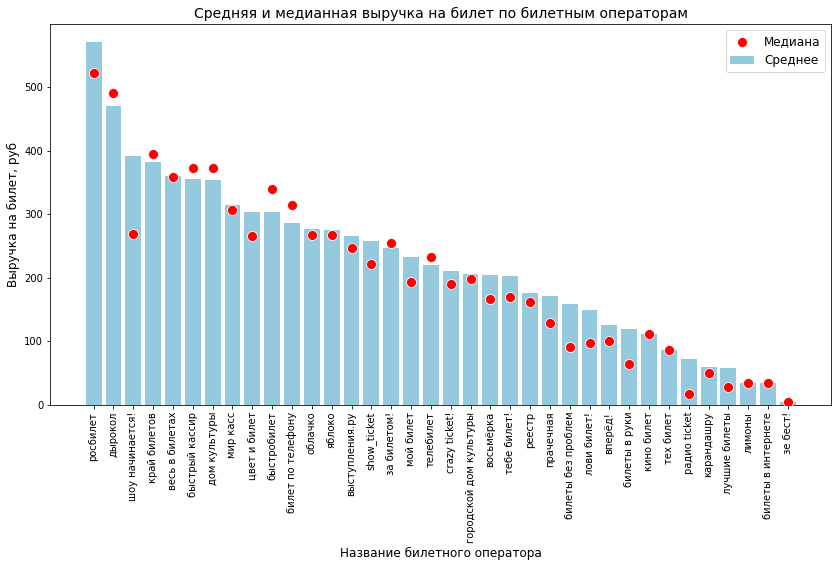

In [23]:
grouped_by_event_type = pos_rev_df.groupby(by='service_name').mean().reset_index()

median_values = pos_rev_df.groupby(by='service_name')['rev_per_ticket'].median().reset_index()
median_values.columns = ['service_name', 'median_rev']

grouped_by_event_type = grouped_by_event_type.merge(median_values, on='service_name')
grouped_by_event_type = grouped_by_event_type.sort_values(by='rev_per_ticket', ascending=False)

plt.figure(figsize=(14, 7))

ax = sns.barplot(data=grouped_by_event_type,
            x='service_name',
            y='rev_per_ticket',
            color='skyblue',
            label='Среднее')

sns.scatterplot(data=grouped_by_event_type,
               x='service_name',
               y='median_rev',
               color='red',
               s=100,
               marker='o',
               label='Медиана',
               zorder=5)

plt.title('Средняя и медианная выручка на билет по билетным операторам', fontsize=14)
plt.xticks(rotation=90)
plt.xlabel('Название билетного оператора', fontsize=12)
plt.ylabel('Выручка на билет, руб', fontsize=12)
plt.legend(fontsize=12)
plt.show()

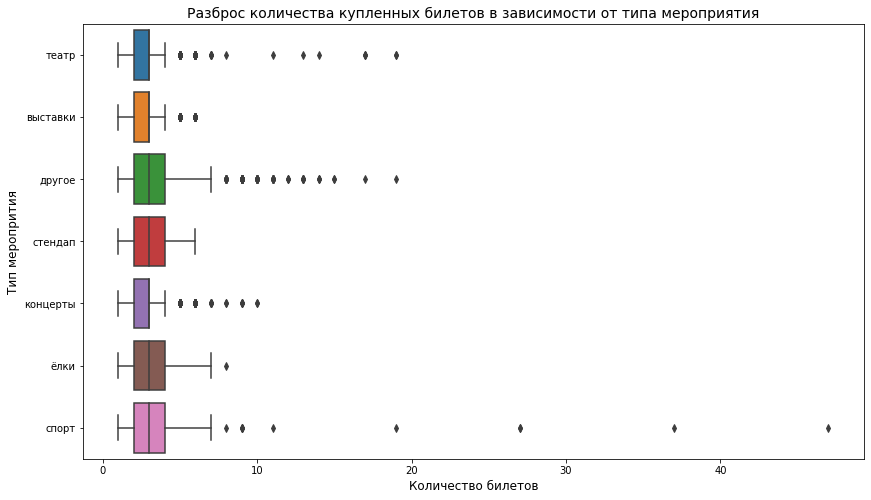

In [24]:
plt.figure(figsize=(14 ,8))
sns.boxplot(data=pos_rev_df, x='tickets_count', y='event_type_main')

plt.xlabel('Количество билетов', fontsize=12)
plt.ylabel('Тип меропрития', fontsize=12)
plt.title('Разброс количества купленных билетов в зависимости от типа мероприятия', fontsize=14)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)
plt.show()

Промежуточные выводы:
  - Текстовые столбцы датафрейма были приведены к нижнему регистру
  - При анализе рублевой выручки по типу мероприятия были найдены очень высокие значения-выбросы, поэтому датафрейм был отфильтрован по рублей выручке по 99 перцентилю
  - Также в датафрейме были обнаружены строки с отрицательными значениями в выручке, такие строки были удалены
  - Всего было удалено 8732 строк, что соответствует 3% строк от начального размера датафрейма
  - 80% первых заказов было сделано с мобильных устройств, 20% с компьютеров
  - В количестве билетов также найдены аномально высокие значения
  - был создан новый столбец rev_per_ticket для выручки на один билет

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [25]:
pos_rev_df_sorted = pos_rev_df.sort_values(by='order_ts', ascending=True)

In [26]:
user_df = pos_rev_df_sorted.groupby('user_id').agg(
    first_order=('order_ts', 'min'),
    last_order=('order_ts', 'max'),
    total_orders=('order_id', 'nunique'),
    avg_order_rev=('revenue_rub', 'mean'),
    avg_tickets_count=('tickets_count', 'mean'),
    avg_days_since_prev=('days_since_prev', 'mean'),
    avg_revenue_rub=('rev_per_ticket', 'mean')
).reset_index()

In [27]:
user_df = user_df.merge(pos_rev_df, left_on=['user_id', 'first_order'], right_on=['user_id', 'order_ts'])
user_df = user_df[['user_id', 'first_order', 'last_order', 'device_type_canonical',
                   'region_name', 'service_name', 'event_type_main',
                   'total_orders', 'avg_order_rev', 'avg_tickets_count',
                  'avg_days_since_prev', 'avg_revenue_rub']]

user_df['is_five'] = (user_df['total_orders'] >= 5).astype(int)
user_df['is_two'] = (user_df['total_orders'] >= 2).astype(int)

user_df['is_five'] = pd.to_numeric(user_df['is_five'], downcast='integer')
user_df['is_two'] = pd.to_numeric(user_df['is_two'], downcast='integer')

In [28]:
user_df.head(3)

,user_id,first_order,last_order,device_type_canonical,region_name,service_name,event_type_main,total_orders,avg_order_rev,avg_tickets_count,avg_days_since_prev,avg_revenue_rub,is_five,is_two
0,0002849b70a3ce2,2024-08-20 16:08:03,2024-08-20 16:08:03,mobile,каменевский регион,край билетов,театр,1,1521.940000,4.000000,NaN,380.485000,0,0
1,0005ca5e93f2cf4,2024-07-23 18:36:24,2024-10-06 13:56:02,mobile,каменевский регион,мой билет,выставки,2,774.010000,3.000000,75.0,229.683750,0,1
2,000898990054619,2024-07-13 19:40:48,2024-10-23 15:12:00,mobile,североярская область,лови билет!,другое,3,767.213333,2.666667,51.0,256.209444,0,1


---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [29]:
print(f"Общее число пользователей: {user_df.shape[0]}")
print(f"Средняя выручка заказа {user_df['avg_order_rev'].mean():.2f} руб.")
print(f"Медиана выручки заказа {user_df['avg_order_rev'].median():.2f} руб.")
print(f"Доля пользователей, совершивших 2 и более заказа: {user_df['is_two'].sum() / user_df.shape[0] * 100:.2f}%")
print(f"Доля пользователей, совершивших 2 и более заказа: {user_df['is_five'].sum() / user_df.shape[0] * 100:.2f}%")

print(f"Общее количество заказов: {user_df['total_orders'].sum()} шт.")
print(f"Среднее количество билетов в заказе: {user_df['avg_tickets_count'].mean():.2f}")
print(f"Медиана количества билетов в заказе: {user_df['avg_tickets_count'].median():.2f}")
print(f"Среднее количество дней между покупками (среди тех у кого был повторный заказ): {user_df['avg_days_since_prev'].mean():.2f}")

Общее число пользователей: 21700
Средняя выручка заказа 551.88 руб.
Медиана выручки заказа 475.97 руб.
Доля пользователей, совершивших 2 и более заказа: 61.67%
Доля пользователей, совершивших 2 и более заказа: 28.87%
Общее количество заказов: 281879 шт.
Среднее количество билетов в заказе: 2.75
Медиана количества билетов в заказе: 2.75
Среднее количество дней между покупками (среди тех у кого был повторный заказ): 15.92


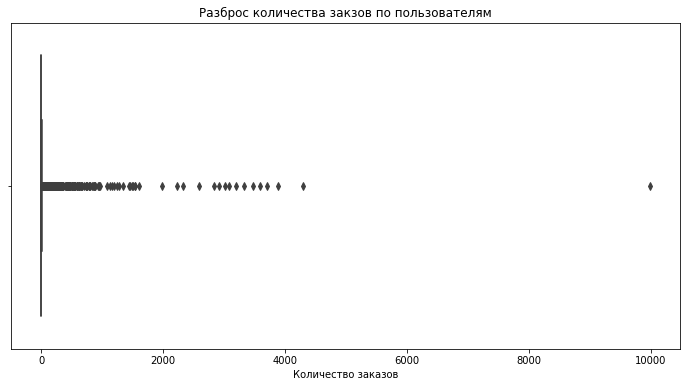

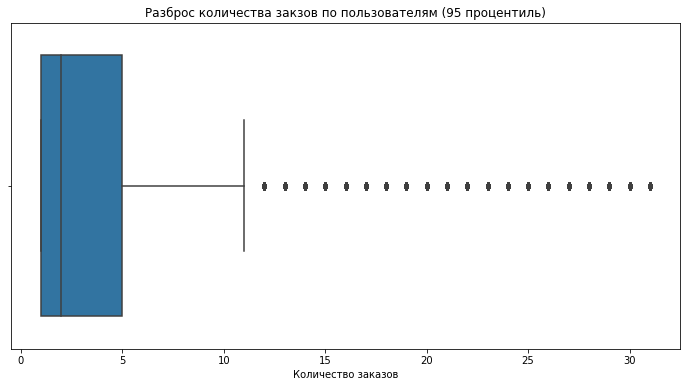

In [30]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=user_df, x='total_orders')
plt.title('Разброс количества закзов по пользователям')
plt.xlabel('Количество заказов')
plt.show()

plt.figure(figsize=(12, 6))
percentile_95 = user_df['total_orders'].quantile(0.95)
user_df = user_df[user_df['total_orders']<=percentile_95]
sns.boxplot(data=user_df, x='total_orders')
plt.title('Разброс количества закзов по пользователям (95 процентиль)')
plt.xlabel('Количество заказов')
plt.show()

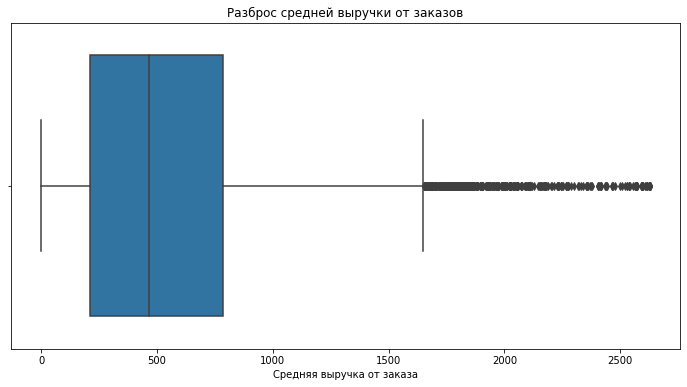

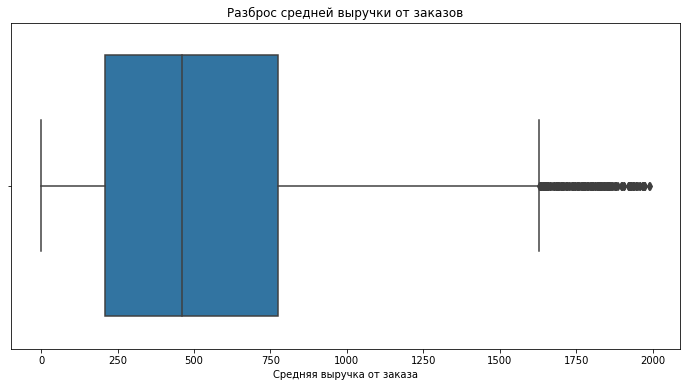

In [31]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=user_df, x='avg_order_rev')
plt.title('Разброс средней выручки от заказов')
plt.xlabel('Средняя выручка от заказа')
plt.show()

plt.figure(figsize=(12, 6))
percentile_99 = user_df['avg_order_rev'].quantile(0.99)
user_df = user_df[user_df['avg_order_rev']<=percentile_99]
sns.boxplot(data=user_df, x='avg_order_rev')
plt.title('Разброс средней выручки от заказов')
plt.xlabel('Средняя выручка от заказа')
plt.show()

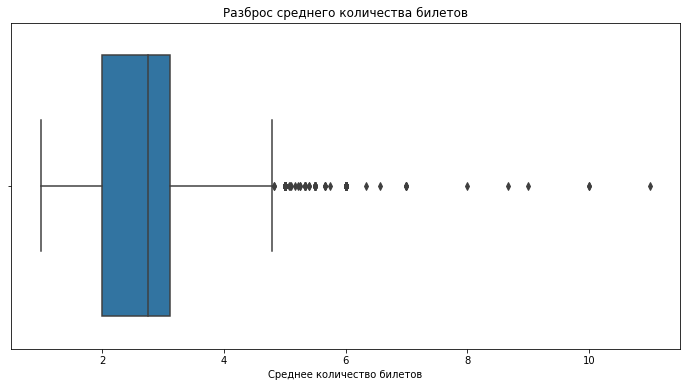

In [32]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=user_df, x='avg_tickets_count')
plt.title('Разброс среднего количества билетов')
plt.xlabel('Среднее количество билетов')
plt.show()

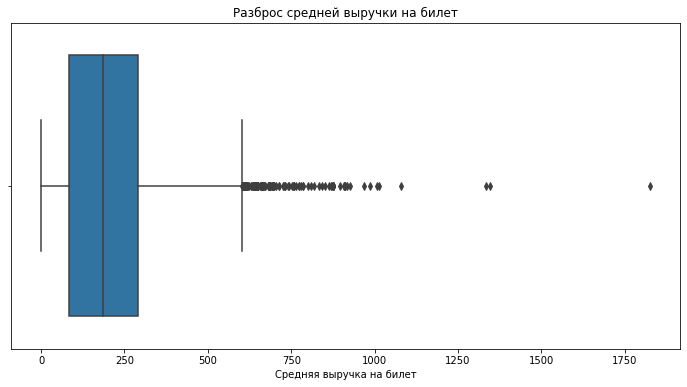

In [33]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=user_df, x='avg_revenue_rub')
plt.title('Разброс средней выручки на билет')
plt.xlabel('Средняя выручка на билет')
plt.show()

In [34]:
print(f"Общее число пользователей: {user_df.shape[0]}")
print(f"Средняя выручка заказа {user_df['avg_order_rev'].mean():.2f} руб.")
print(f"Медиана выручки заказа {user_df['avg_order_rev'].median():.2f} руб.")
print(f"Доля пользователей, совершивших 2 и более заказа: {user_df['is_two'].sum() / user_df.shape[0] * 100:.2f}%")
print(f"Доля пользователей, совершивших 2 и более заказа: {user_df['is_five'].sum() / user_df.shape[0] * 100:.2f}%")

print(f"Общее количество заказов: {user_df['total_orders'].sum()} шт.")
print(f"Среднее количество билетов в заказе: {user_df['avg_tickets_count'].mean():.2f}")
print(f"Медиана количества билетов в заказе: {user_df['avg_tickets_count'].median():.2f}")
print(f"Среднее количество дней между покупками (среди тех у кого был повторный заказ): {user_df['avg_days_since_prev'].mean():.2f}")

Общее число пользователей: 20419
Средняя выручка заказа 536.56 руб.
Медиана выручки заказа 460.86 руб.
Доля пользователей, совершивших 2 и более заказа: 60.04%
Доля пользователей, совершивших 2 и более заказа: 25.39%
Общее количество заказов: 82834 шт.
Среднее количество билетов в заказе: 2.73
Медиана количества билетов в заказе: 2.75
Среднее количество дней между покупками (среди тех у кого был повторный заказ): 17.16


Промежуточные выводы:
  - В сформированном датафрейме были найдены аномальные значения во всех числовых столбцах
  - Для сокращения таких выбросов данные были урезены до 95 процентиля по количеству заказов и 99 процентиля по средней выручке на заказ
  - Таким образом, из датафрейма пользователей было удалено 1281 запись, что соответсвует 5.9% от общего числа записей.

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [35]:
user_df['is_return'] = (user_df['total_orders'] > 1).astype(int)
user_df.head(3)

,user_id,first_order,last_order,device_type_canonical,region_name,service_name,event_type_main,total_orders,avg_order_rev,avg_tickets_count,avg_days_since_prev,avg_revenue_rub,is_five,is_two,is_return
0,0002849b70a3ce2,2024-08-20 16:08:03,2024-08-20 16:08:03,mobile,каменевский регион,край билетов,театр,1,1521.940000,4.000000,NaN,380.485000,0,0,0
1,0005ca5e93f2cf4,2024-07-23 18:36:24,2024-10-06 13:56:02,mobile,каменевский регион,мой билет,выставки,2,774.010000,3.000000,75.0,229.683750,0,1,1
2,000898990054619,2024-07-13 19:40:48,2024-10-23 15:12:00,mobile,североярская область,лови билет!,другое,3,767.213333,2.666667,51.0,256.209444,0,1,1


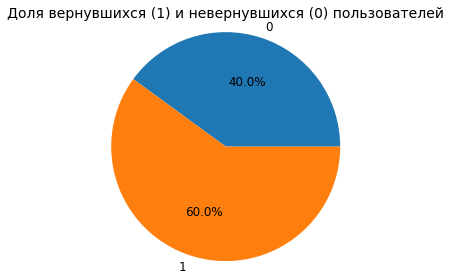

Количество вернувшихся пользователей: 12260
Количество невернувшихся пользователей: 8159


In [36]:
users_series = user_df.groupby(by='is_return')['is_return'].count()

fig, ax = plt.subplots()
ax.pie(users_series,
       labels=users_series.index,
       radius=1.2,
       autopct='%.1f%%',
       textprops=dict(color='black', fontsize=12))

ax.set_title('Доля вернувшихся (1) и невернувшихся (0) пользователей',
            fontsize=14, pad=10)
plt.tight_layout()
plt.show()

print(f"Количество вернувшихся пользователей: {users_series[1]}")
print(f"Количество невернувшихся пользователей: {users_series[0]}")

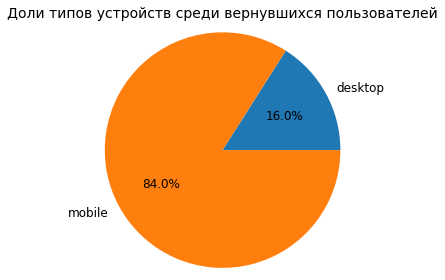

Количество вернувшихся пользователей с первым заказом через телефон: 6854
Количество вернувшихся пользователей с первым заказом через компьютер: 1305


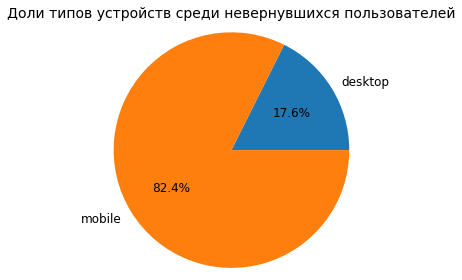

Количество невернувшихся пользователей с первым заказом через телефон: 10100
Количество невернувшихся пользователей с первым заказом через компьютер: 2160


In [37]:
device_df = user_df.groupby(['is_return', 'device_type_canonical']).agg(
    device_count=('user_id', 'count')
).reset_index()

titles = ['вернувшихся', 'невернувшихся']
for i in device_df['is_return'].unique():
    graph_df = device_df[device_df['is_return']==i]
    
    fig, ax = plt.subplots()
    ax.pie(graph_df['device_count'],
           labels=graph_df['device_type_canonical'],
           radius=1.2,
           autopct='%.1f%%',
           textprops=dict(color='black', fontsize=12))

    ax.set_title(f'Доли типов устройств среди {titles[i]} пользователей',
                fontsize=14, pad=10)
    plt.tight_layout()
    plt.show()
    print(f"Количество {titles[i]} пользователей с первым заказом через телефон: \
{int(device_df[(device_df['is_return']==i) & (device_df['device_type_canonical']=='mobile')]['device_count'])}")
    print(f"Количество {titles[i]} пользователей с первым заказом через компьютер: \
{int(device_df[(device_df['is_return']==i) & (device_df['device_type_canonical']=='desktop')]['device_count'])}")

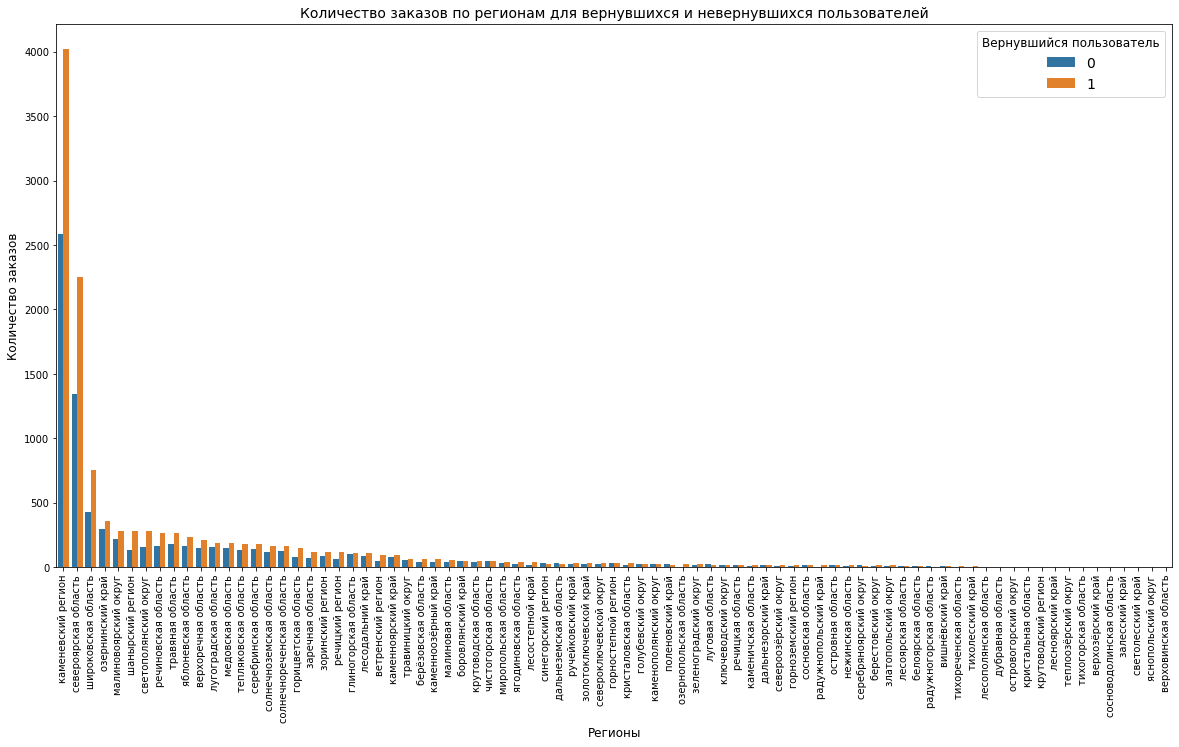

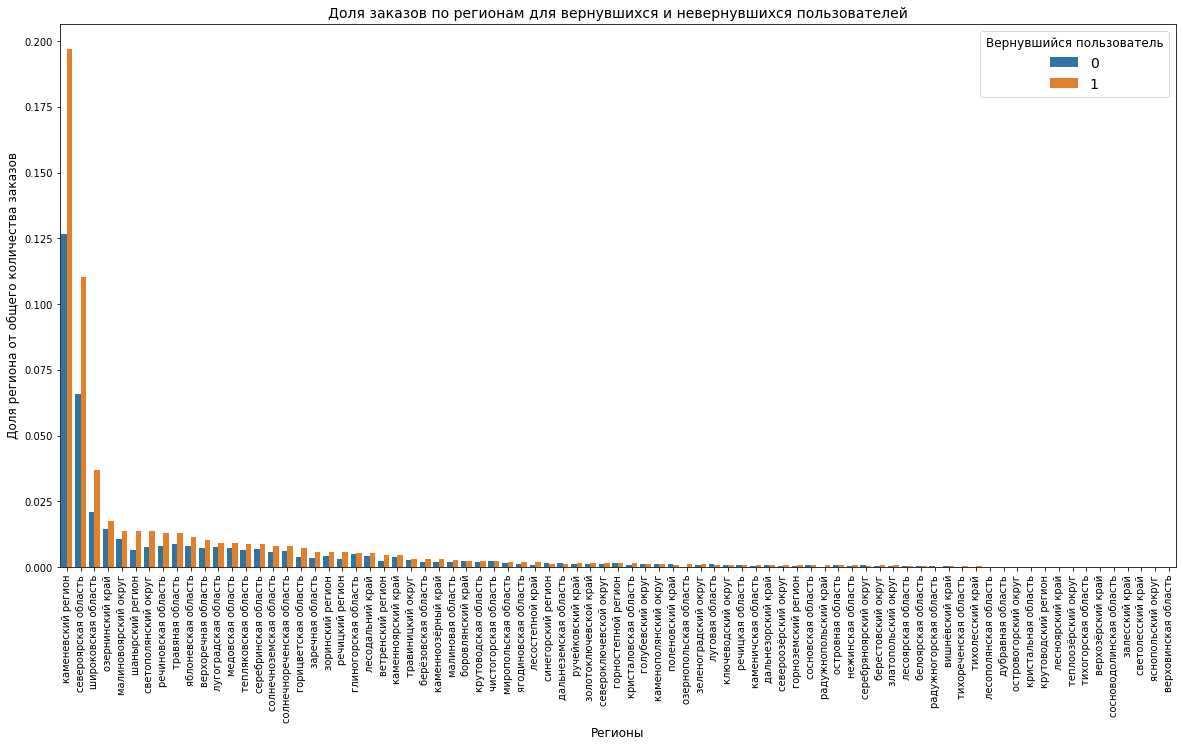

In [38]:
region_df = user_df.groupby(['is_return', 'region_name']).agg(
    region_count=('user_id', 'count')
).reset_index()

unreturn_total = region_df[region_df['is_return']==0]['region_count'].sum()
return_total = region_df[region_df['is_return']==1]['region_count'].sum()

region_df = region_df.sort_values(by='region_count', ascending=False)


# барплот по количеству
plt.figure(figsize=(20, 10))
sns.barplot(data=region_df, x="region_name", y="region_count", hue="is_return")

plt.title('Количество заказов по регионам для вернувшихся и невернувшихся пользователей', fontsize=14)
plt.xlabel('Регионы', fontsize=12)
plt.ylabel('Количество заказов', fontsize=12)
plt.xticks(rotation=90)
plt.legend(
    title='Вернувшийся пользователь',
    loc='upper right',
    fontsize=14,
    title_fontsize=12,
    frameon=True,
)
plt.show()

region_df['region_share'] = region_df['region_count'] / (unreturn_total+return_total)

plt.figure(figsize=(20, 10))
sns.barplot(data=region_df, x="region_name", y="region_share", hue="is_return")

plt.title('Доля заказов по регионам для вернувшихся и невернувшихся пользователей', fontsize=14)
plt.xlabel('Регионы', fontsize=12)
plt.ylabel('Доля региона от общего количества заказов', fontsize=12)
plt.xticks(rotation=90)
plt.legend(
    title='Вернувшийся пользователь',
    loc='upper right',
    fontsize=14,
    title_fontsize=12,
    frameon=True,
)
plt.show()

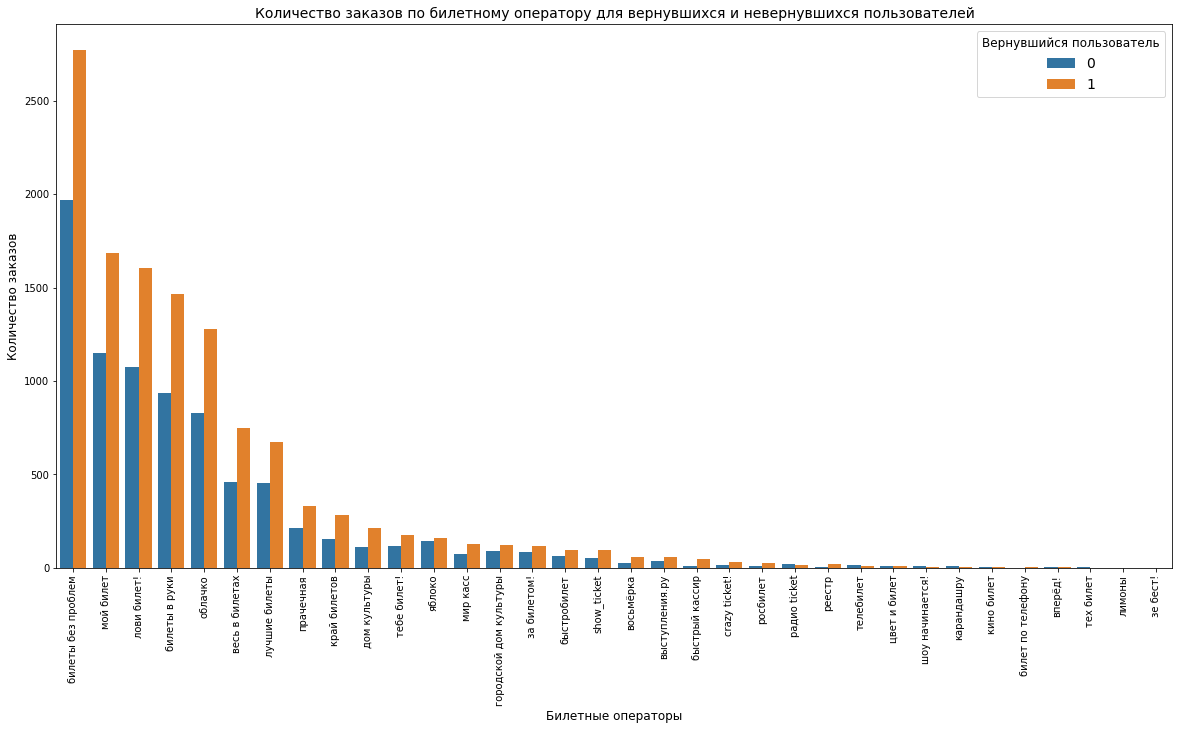

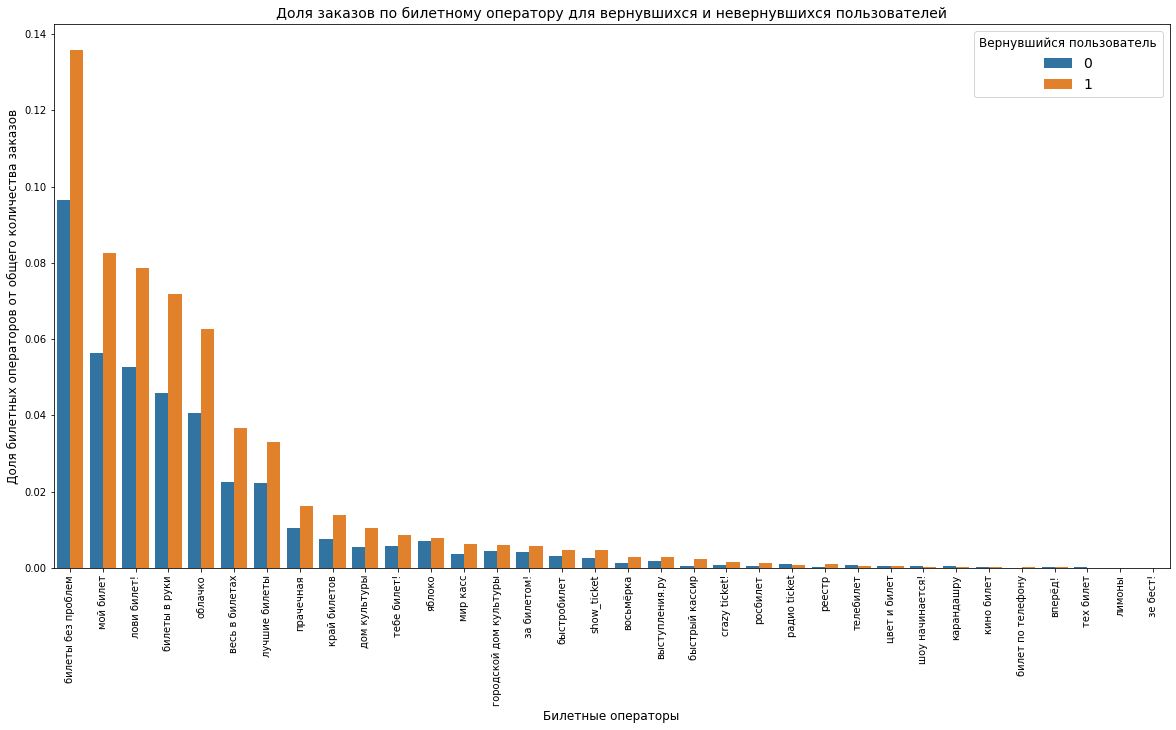

In [39]:
service_df = user_df.groupby(['is_return', 'service_name']).agg(
    service_count=('user_id', 'count')
).reset_index()

unreturn_total = service_df[service_df['is_return']==0]['service_count'].sum()
return_total = service_df[service_df['is_return']==1]['service_count'].sum()

service_df = service_df.sort_values(by='service_count', ascending=False)

# барплот для количества
plt.figure(figsize=(20, 10))
sns.barplot(data=service_df, x="service_name", y="service_count", hue="is_return")

plt.title('Количество заказов по билетному оператору для вернувшихся и невернувшихся пользователей', fontsize=14)
plt.xlabel('Билетные операторы', fontsize=12)
plt.ylabel('Количество заказов', fontsize=12)
plt.xticks(rotation=90)
plt.legend(
    title='Вернувшийся пользователь',
    loc='upper right',
    fontsize=14,
    title_fontsize=12,
    frameon=True,
)
plt.show()


service_df['service_share'] = service_df['service_count'] / (unreturn_total+return_total)

plt.figure(figsize=(20, 10))
sns.barplot(data=service_df, x="service_name", y="service_share", hue="is_return")

plt.title('Доля заказов по билетному оператору для вернувшихся и невернувшихся пользователей', fontsize=14)
plt.xlabel('Билетные операторы', fontsize=12)
plt.ylabel('Доля билетных операторов от общего количества заказов', fontsize=12)
plt.xticks(rotation=90)
plt.legend(
    title='Вернувшийся пользователь',
    loc='upper right',
    fontsize=14,
    title_fontsize=12,
    frameon=True,
)
plt.show()

In [40]:
service_df

,is_return,service_name,service_count,service_share
36,1,билеты без проблем,2773,0.135805
3,0,билеты без проблем,1971,0.096528
55,1,мой билет,1688,0.082668
52,1,лови билет!,1605,0.078603
37,1,билеты в руки,1468,0.071894
...,...,...,...,...
17,0,лимоны,1,0.000049
51,1,лимоны,1,0.000049
2,0,билет по телефону,1,0.000049
47,1,зе бест!,1,0.000049


Промежуточные выводы:
  - Большая часть пользователей имеют больше одной покупки (12260 вернувшихся и 8159 невернувшихся)
  - Около 82% пользователей как среди вернувшихся, так и невернувшихся использовали телефон при первом заказе
  - Большая часть заказов приходится на 2 региона: каменевский и североярскую области. Существуют регионы в которых доля невернушвихся больше чем вернувшихся, но доля заказов на эти регионы несущественна, среди них: синегорский регион, дальнеземская область и поленовский регион
  - Среди билетных операторов также существуют лидеры по заказам, наиболшее количество заказов с отрывом имеет оператор "билеты без проблем" (4744), далее примерно на одном уровне располагаются еще 4 оператора, остальные имеют незначительные доли от количества заказов.

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


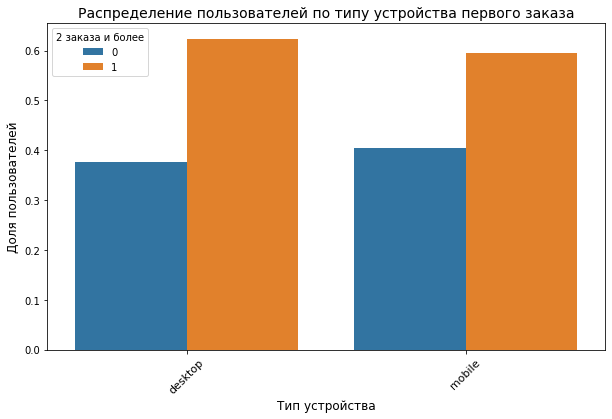

In [41]:
by_device_df = user_df.groupby(['is_two', 'device_type_canonical'])['is_two'].agg(['count']).reset_index()

by_device_df['share'] = None

for index, row in by_device_df.iterrows():
    val = by_device_df[by_device_df['device_type_canonical']==row['device_type_canonical']]['count'].sum()
    by_device_df.at[index, 'share'] = row['count'] / val

plt.figure(figsize=(10, 6))

sns.barplot(data=by_device_df, x='device_type_canonical', y='share', hue='is_two')

plt.title('Распределение пользователей по типу устройства первого заказа', fontsize=14)
plt.xlabel('Тип устройства', fontsize=12)
plt.ylabel('Доля пользователей', fontsize=12)
plt.legend(
    title='2 заказа и более',
)
plt.xticks(rotation=45, fontsize=11)
plt.show()

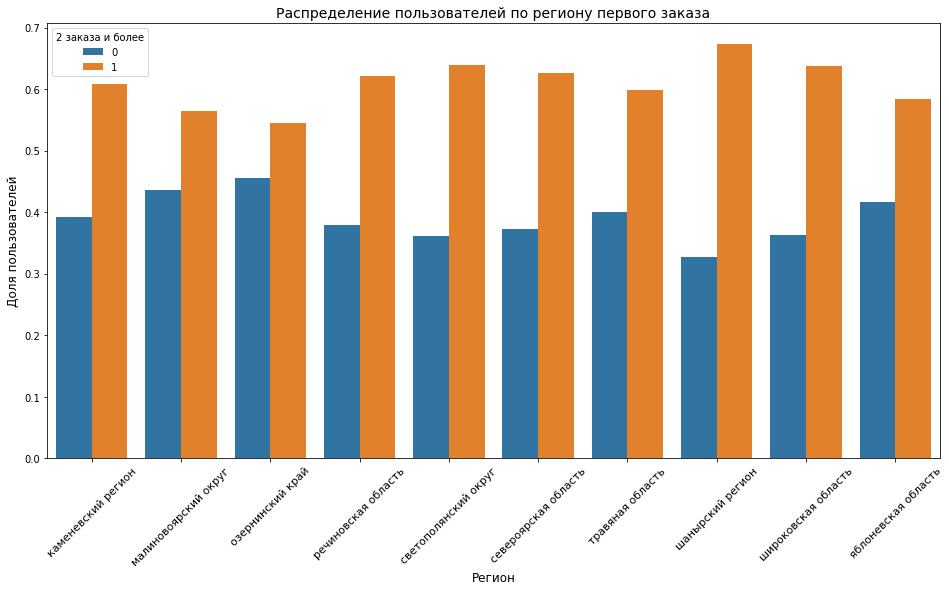

In [42]:
by_region_df = user_df.groupby(['is_two', 'region_name'])['is_two'].agg(['count']).reset_index()
top_10 = by_region_df.groupby('region_name')['count'].sum().sort_values(ascending=False).reset_index().head(10)
by_region_df = by_region_df.merge(top_10[['region_name']], on='region_name', how='inner')

by_region_df['share'] = None

for index, row in by_region_df.iterrows():
    val = by_region_df[by_region_df['region_name']==row['region_name']]['count'].sum()
    by_region_df.at[index, 'share'] = row['count'] / val

plt.figure(figsize=(16, 8))

sns.barplot(data=by_region_df, x='region_name', y='share', hue='is_two')

plt.title('Распределение пользователей по региону первого заказа', fontsize=14)
plt.xlabel('Регион', fontsize=12)
plt.ylabel('Доля пользователей', fontsize=12)
plt.legend(
    title='2 заказа и более',
)
plt.xticks(rotation=45, fontsize=11)
plt.show()

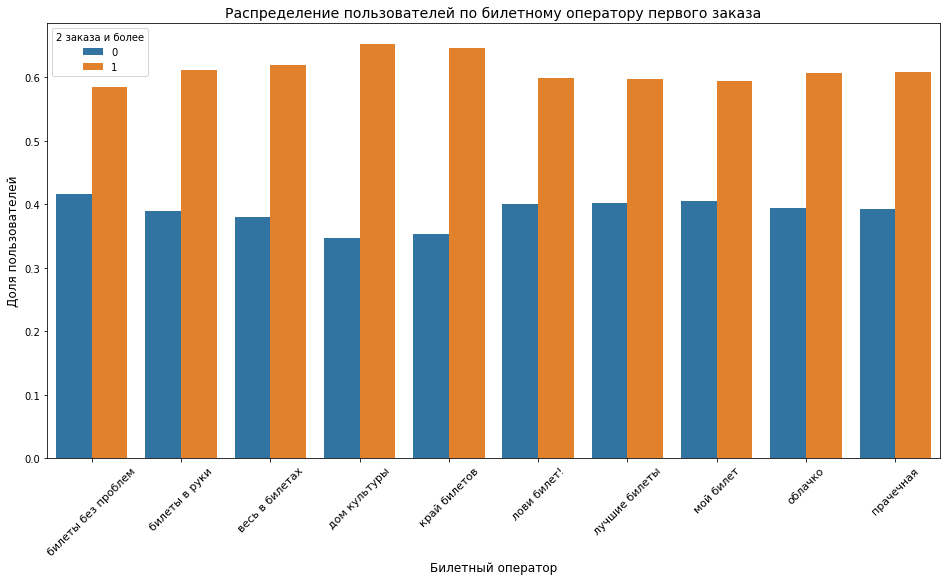

In [43]:
by_service_df = user_df.groupby(['is_two', 'service_name'])['is_two'].agg(['count']).reset_index()
top_10 = by_service_df.groupby('service_name')['count'].sum().sort_values(ascending=False).reset_index().head(10)
by_service_df = by_service_df.merge(top_10[['service_name']], on='service_name', how='inner')

by_service_df['share'] = None

for index, row in by_service_df.iterrows():
    val = by_service_df[by_service_df['service_name']==row['service_name']]['count'].sum()
    by_service_df.at[index, 'share'] = row['count'] / val

plt.figure(figsize=(16, 8))

sns.barplot(data=by_service_df, x='service_name', y='share', hue='is_two')

plt.title('Распределение пользователей по билетному оператору первого заказа', fontsize=14)
plt.xlabel('Билетный оператор', fontsize=12)
plt.ylabel('Доля пользователей', fontsize=12)
plt.legend(
    title='2 заказа и более',
)
plt.xticks(rotation=45, fontsize=11)
plt.show()

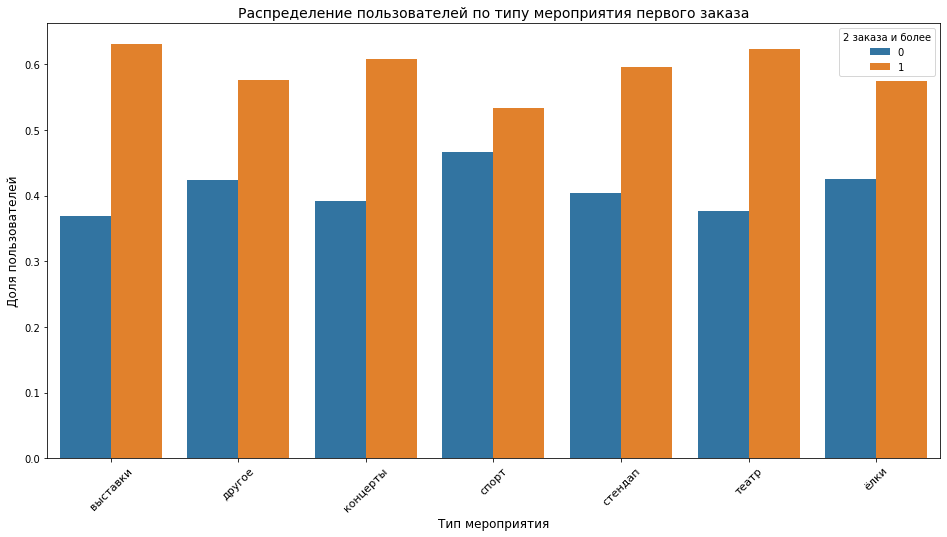

In [44]:
by_event_name_df = user_df.groupby(['is_two', 'event_type_main'])['is_two'].agg(['count']).reset_index()

by_event_name_df['share'] = None

for index, row in by_event_name_df.iterrows():
    val = by_event_name_df[by_event_name_df['event_type_main']==row['event_type_main']]['count'].sum()
    by_event_name_df.at[index, 'share'] = row['count'] / val

plt.figure(figsize=(16, 8))

sns.barplot(data=by_event_name_df, x='event_type_main', y='share', hue='is_two')

plt.title('Распределение пользователей по типу мероприятия первого заказа', fontsize=14)
plt.xlabel('Тип мероприятия', fontsize=12)
plt.ylabel('Доля пользователей', fontsize=12)
plt.legend(
    title='2 заказа и более',
)
plt.xticks(rotation=45, fontsize=11)
plt.show()

Промежуточные выводы:
  - Пользователи, которые совершили первый заказ через компьютер чуть более склонны совершать повторный заказ
  - Во всех ТОП-10 регионов по количеству заказов доля пользователей соверщающих повторный заказ выше, чем пользователей с единичным заказом. Также наблюдается регионы в которых пользователи более склонны к совершению повторного заказа, например, среди таких шанырский регион (70.8%), светополянский регион (66.3%) и широковская область (65.1%), однако существует и регионы с относительно низким показателем возврата, такие как: озернинский край (44.9%) и малиновоярский округ (43.7%)
  - Выраженной зависимости между возвратом пользователя и билетным оператором не выявлено
  - Пользователи, которые совершили первый заказ на мероприятия типов выставки, театр и концерты более склонны к повторным заказам, процент возврата по ним 64.3%, 64% и 62.4% соответственно. Наименьшиу доли возврата наблюдаются в категориях "спорт" (55.3%) и "елки" (55.7%)

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

<b>Выводы по гипотезам:</b>
  1. Гипотеза 1 не подвтердилась: Тип мероприятия действительно влияет на вероятность возврата на Яндекс Афишу, однако, пользователи, совершившие первый заказ на спортивные мероприятия оказались менее склонными к повтороному заказу по сравнению с теми, кто предпочел концерты в качестве первого заказа. Процент возврата: 55.3% у "спорта" против "62.4% у "концертов".
  2. Гипотеза 2 не подвтердилась: среди ТОП-10 регионов по количеству заказов не выявлено зависимости между количеством заказов и долей возврата пользователей, совершивших первых заказ в этом регионе. Например, в каменевском регионе (топ-1 по количеству заказов) количество заказов составляет 7094, процент возврата 62.4%, а в шанырском регионе (топ-5 по количеству заказов), количество заказов 473, а процент возврата 70.8%.

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


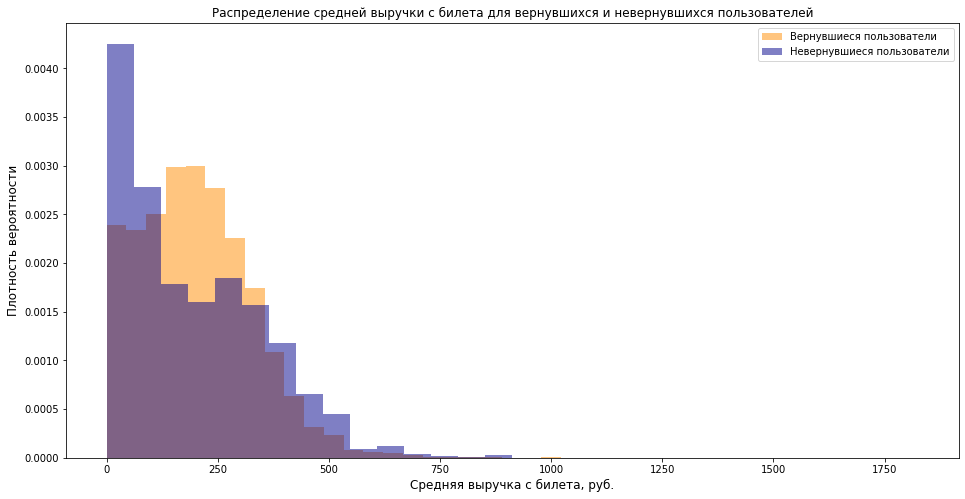

In [45]:
return_df = user_df[(user_df['is_two']==1)  & (user_df['avg_revenue_rub']<2_000)]['avg_revenue_rub']

unreturn_df = user_df[(user_df['is_two']==0) & (user_df['avg_revenue_rub']<2_000)]['avg_revenue_rub']

plt.figure(figsize=(16, 8))
plt.hist(x=return_df, label='Вернувшиеся пользователи', alpha=0.5, bins=30, density=True, color='darkorange')
plt.hist(x=unreturn_df, label='Невернувшиеся пользователи', alpha=0.5, bins=30, density=True, color='darkblue')

plt.title('Распределение средней выручки с билета для вернувшихся и невернувшихся пользователей', fontsize=12)
plt.xlabel('Средняя выручка с билета, руб.', fontsize=12)
plt.ylabel('Плотность вероятности', fontsize=12)
plt.legend()
plt.show()

Ответы на вопросы:
  - Большая часть выручки с билета как для вернувшихся, так и для невернувшихся пользователей не превышает 500 руб.
  - Для невернувшихся пользователей значение средней выручки с билета чаще ниже чем для вернувшихся пользователей.

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


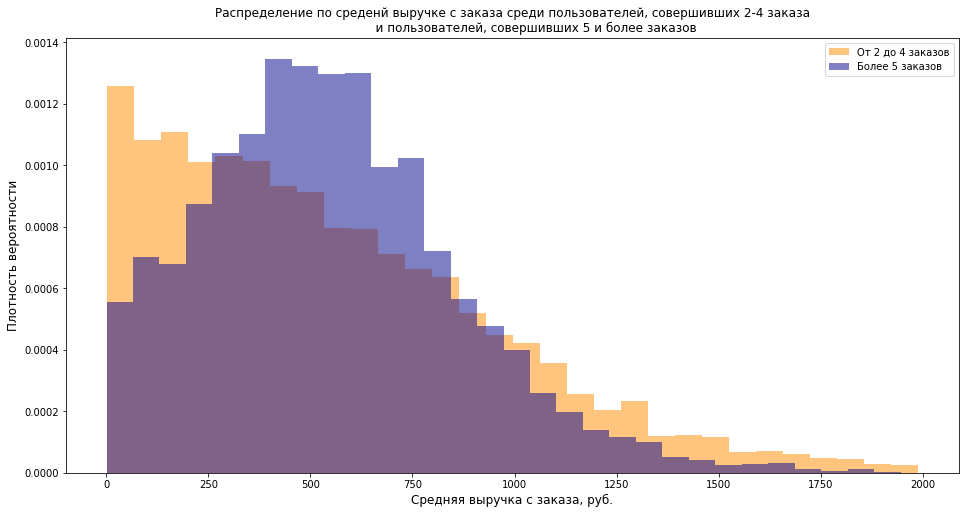

In [46]:
two_four_ord_df = user_df[(user_df['total_orders']>=2) & (user_df['total_orders']<=4)
                         & (user_df['avg_order_rev']<5_000)]['avg_order_rev']

more_five_ord_df = user_df[(user_df['total_orders']>=5) & (user_df['avg_order_rev']<5_000)]['avg_order_rev']

plt.figure(figsize=(16, 8))
plt.hist(x=two_four_ord_df, label='От 2 до 4 заказов', alpha=0.5, bins=30, density=True, color='darkorange')
plt.hist(x=more_five_ord_df, label='Более 5 заказов', alpha=0.5, bins=30, density=True, color='darkblue')

plt.title('''Распределение по среденй выручке с заказа среди пользователей, совершивших 2-4 заказа
            и пользователей, совершивших 5 и более заказов''', fontsize=12)
plt.xlabel('Средняя выручка с заказа, руб.', fontsize=12)
plt.ylabel('Плотность вероятности', fontsize=12)
plt.legend()
plt.show()

Ответы на вопросы:
  - Пользователи, которые соврешили от 2 до 4 заказов в среднем имеют меньшее значение выручки с заказа по сравнению с пользователями, которые совершили более 5 заказов

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

In [47]:
user_df.head(3)

,user_id,first_order,last_order,device_type_canonical,region_name,service_name,event_type_main,total_orders,avg_order_rev,avg_tickets_count,avg_days_since_prev,avg_revenue_rub,is_five,is_two,is_return
0,0002849b70a3ce2,2024-08-20 16:08:03,2024-08-20 16:08:03,mobile,каменевский регион,край билетов,театр,1,1521.940000,4.000000,NaN,380.485000,0,0,0
1,0005ca5e93f2cf4,2024-07-23 18:36:24,2024-10-06 13:56:02,mobile,каменевский регион,мой билет,выставки,2,774.010000,3.000000,75.0,229.683750,0,1,1
2,000898990054619,2024-07-13 19:40:48,2024-10-23 15:12:00,mobile,североярская область,лови билет!,другое,3,767.213333,2.666667,51.0,256.209444,0,1,1


Количество пользователей совершивших повтроные заказы в сегменте от 1 до 2 билетов: 1220 (51.11%)
Количество пользователей не совершивших повтроные заказы в сегменте от 1 до 2 билетов: 1167 (48.89%)


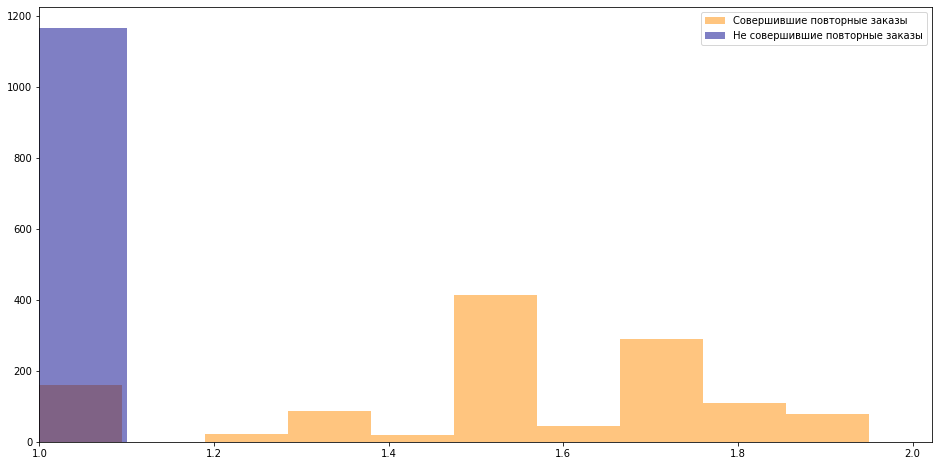

Количество пользователей совершивших повтроные заказы в сегменте от 2 до 3 билетов: 6181 (71.27%)
Количество пользователей не совершивших повтроные заказы в сегменте от 2 до 3 билетов: 2492 (28.73%)


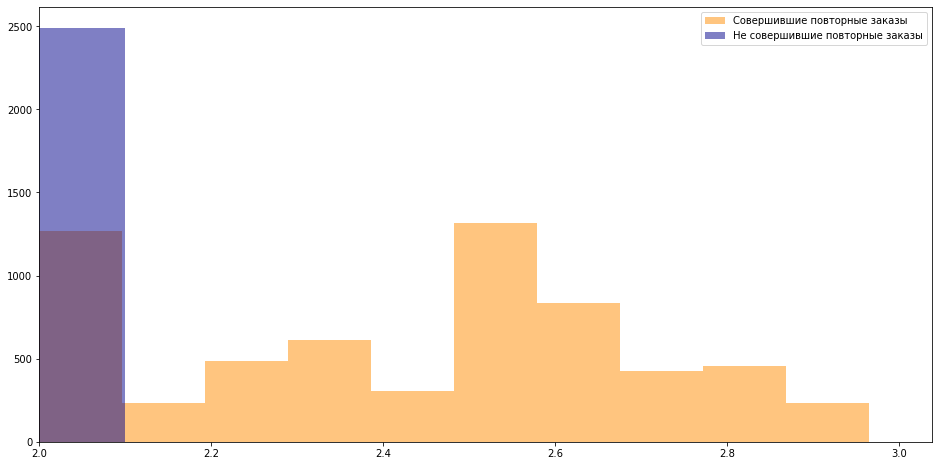

Количество пользователей совершивших повтроные заказы в сегменте от 3 до 5 билетов: 4745 (54.19%)
Количество пользователей не совершивших повтроные заказы в сегменте от 3 до 5 билетов: 4011 (45.81%)


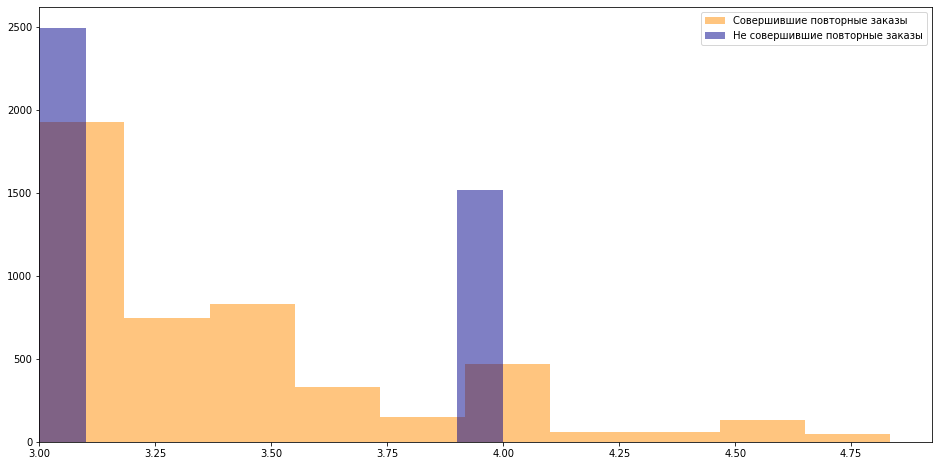

Количество пользователей совершивших повтроные заказы в сегменте от 5 до 100 билетов: 114 (18.91%)
Количество пользователей не совершивших повтроные заказы в сегменте от 5 до 100 билетов: 489 (81.09%)


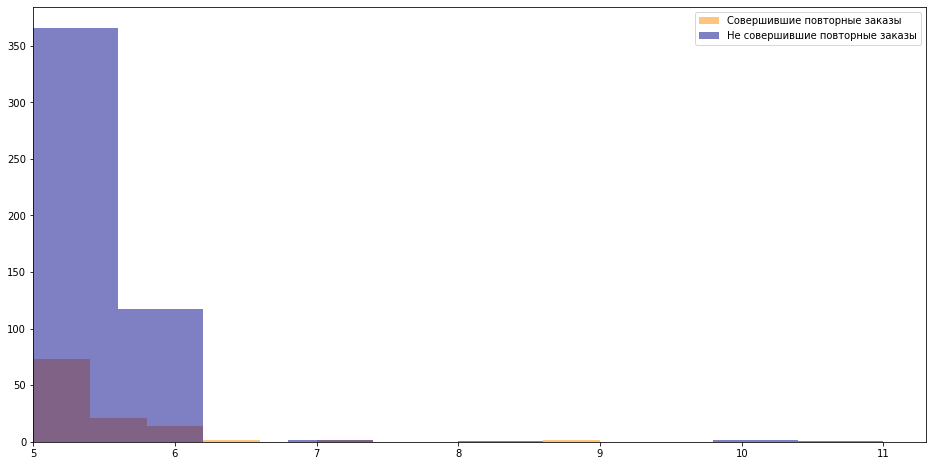

In [48]:
tickers = [1, 2, 3, 5, 100]
low_val = tickers[0]

for ticker_val in tickers[1:]:
 
    ticker_return_df = user_df[(user_df['avg_tickets_count']<ticker_val)
                               & (user_df['avg_tickets_count']>=low_val)
                               & (user_df['is_return']==1)]['avg_tickets_count']

    ticker_unreturn_df = user_df[(user_df['avg_tickets_count']<ticker_val)
                                 & (user_df['avg_tickets_count']>=low_val)
                                 & (user_df['is_return']==0)]['avg_tickets_count']
    
    
    share_of_return = ticker_return_df.shape[0] / (ticker_return_df.shape[0] + ticker_unreturn_df.shape[0])
    share_of_unreturn = ticker_unreturn_df.shape[0] / (ticker_return_df.shape[0] + ticker_unreturn_df.shape[0])
    
    print(f"Количество пользователей совершивших повтроные заказы в сегменте \
от {low_val} до {ticker_val} билетов: {ticker_return_df.shape[0]} ({share_of_return * 100:.2f}%)")
    print(f"Количество пользователей не совершивших повтроные заказы в сегменте \
от {low_val} до {ticker_val} билетов: {ticker_unreturn_df.shape[0]} ({share_of_unreturn * 100:.2f}%)")
    


    plt.figure(figsize=(16, 8))
    plt.hist(x=ticker_return_df, label='Совершившие повторные заказы', alpha=0.5, bins=10, color='darkorange')
    plt.hist(x=ticker_unreturn_df, label='Не совершившие повторные заказы', alpha=0.5, bins=10, color='darkblue')
    
    plt.xlim(low_val)
    plt.legend()
    plt.show()
    
    
    if ticker_val == 100:
        break
        
    low_val = ticker_val

Ответы на вопросы:
  - В сегментах где среднее количество купленных билетов от 1 до 2 и от 3 до 5 пользователи распределены примерно 50% на 50. В сегменте от 2 до 3 билетов, количество пользователей с возвратом сильно превосходит невозвратных пользователей (74% против 26%). В сегменте 5+ билетов ситуация обратная, клиентов с единичной покупкой намного больше, чем пользователей с повторным заказом (19.42% против 80.58%).

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


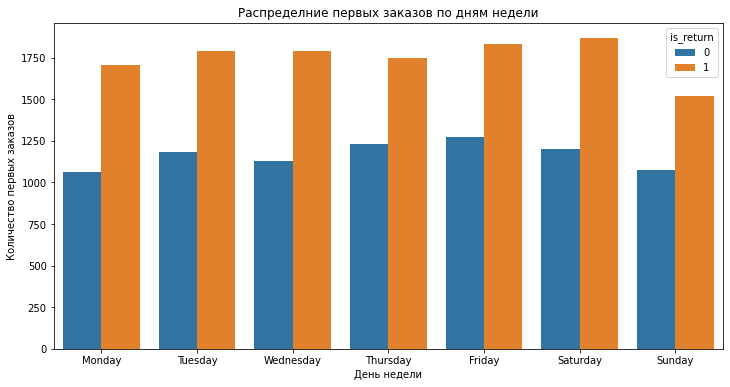

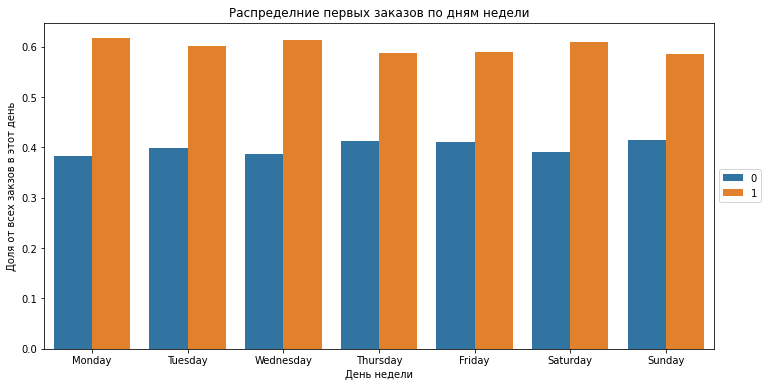

In [49]:
user_df['day_of_week'] = user_df['first_order'].dt.day_name()

weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 
                 'Friday', 'Saturday', 'Sunday']

user_df['day_of_week'] = pd.Categorical(
    user_df['day_of_week'], 
    categories=weekday_order,
    ordered=True
)

by_day_of_week_df = user_df.groupby(['day_of_week', 'is_return'])['user_id'].count().reset_index()

# Барплот в абсолюте
plt.figure(figsize=(12, 6))
sns.barplot(data=by_day_of_week_df, x='day_of_week', y='user_id', hue='is_return')

plt.title('Распределние первых заказов по дням недели')
plt.xlabel('День недели')
plt.ylabel('Количество первых заказов')
plt.show()




grouped_by_day_of_week = by_day_of_week_df.groupby('day_of_week')['user_id'].sum().reset_index()
by_day_of_week_df = by_day_of_week_df.merge(grouped_by_day_of_week,
                                            how='left',
                                            on='day_of_week',
                                            suffixes=('cat_users', 'all_users_in_day'))

# Барплот для долей
by_day_of_week_df['share'] = by_day_of_week_df['user_idcat_users'] / by_day_of_week_df['user_idall_users_in_day']

plt.figure(figsize=(12, 6))
sns.barplot(data=by_day_of_week_df, x='day_of_week', y='share', hue='is_return')

plt.title('Распределние первых заказов по дням недели')
plt.xlabel('День недели')
plt.ylabel('Доля от всех закзов в этот день')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Выводы:
  - ТОП-3 дня недели по количеству первых заказов являются суббота (3426), пятница (3245) и вторник (3200), минимальное количество заказов приходится на воскресенье (2800) и понедельник (2919).
  - День недели не оказывает существенного влияния на возврат пользователей.

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


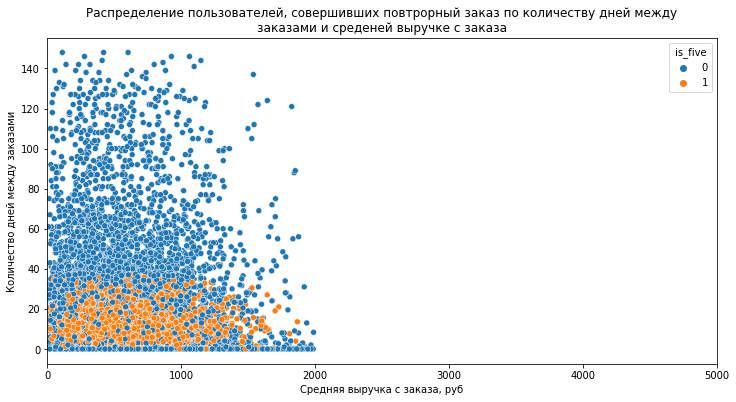

In [50]:
cutted_df = user_df[user_df['is_return']==1]

plt.figure(figsize=(12, 6))
sns.scatterplot(data=cutted_df,
                x='avg_order_rev', y='avg_days_since_prev',
                hue='is_five')

plt.title('''Распределение пользователей, совершивших повтрорный заказ по количеству дней между
заказами и среденей выручке с заказа''')
plt.xlabel('Средняя выручка с заказа, руб')
plt.ylabel('Количество дней между заказами')
plt.xlim((0, 5000))
plt.show()

Промежуточные выводы:
  - Пользователи, совершившие 5 и более заказов совершают заказы в течение 40 дней от предыдущего.
  - Пользователи, севершившие 2-4 заказов имеют более широкий разброс в количестве дней между заказами. Большая их часть сосредоточена в пределах до 80 дней от предыдущего заказа, но немало пользователей и в диапазоне от 80 до 140 дней. Также нужно отмеить, что много пользователей в этом сегменте севершают заказы через пару дней после предыдущего.
  - Средняя выручка с заказа примерно одинакова для каждого сегмента и сосредоточнеа в диапазоне до 2000 руб.

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

interval columns not set, guessing: ['total_orders', 'avg_order_rev', 'avg_tickets_count', 'avg_days_since_prev', 'avg_revenue_rub']


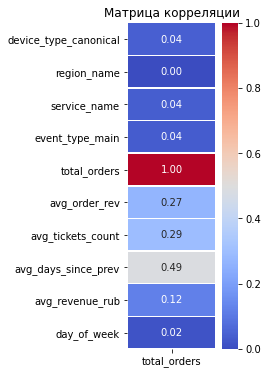

In [51]:
data_for_corr = user_df.drop(columns=['first_order', 'last_order', 'user_id', 'is_five', 'is_two', 'is_return'])
corr_data = data_for_corr.phik_matrix()

corr_data = corr_data[['total_orders']]

plt.figure(figsize=(2, 6))
sns.heatmap(data=corr_data, annot=True, fmt='.2f', linewidths=0.5, cmap='coolwarm')

plt.title('Матрица корреляции')
plt.show()

interval columns not set, guessing: ['total_orders', 'avg_order_rev', 'avg_tickets_count', 'avg_days_since_prev', 'avg_revenue_rub']


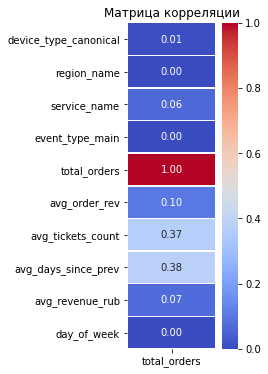

In [52]:
data_for_corr = user_df.drop(columns=['first_order', 'last_order', 'user_id', 'is_five', 'is_two', 'is_return'])
data_for_corr = data_for_corr[(data_for_corr['total_orders']>=2) & (data_for_corr['total_orders']<=4)]


corr_data = data_for_corr.phik_matrix()

corr_data = corr_data[['total_orders']]

plt.figure(figsize=(2, 6))
sns.heatmap(data=corr_data, annot=True, fmt='.2f', linewidths=0.5, cmap='coolwarm')

plt.title('Матрица корреляции')
plt.show()

interval columns not set, guessing: ['total_orders', 'avg_order_rev', 'avg_tickets_count', 'avg_days_since_prev', 'avg_revenue_rub']


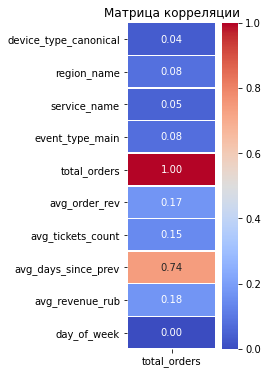

In [53]:
data_for_corr = user_df.drop(columns=['first_order', 'last_order', 'user_id', 'is_five', 'is_two', 'is_return'])
data_for_corr = data_for_corr[(data_for_corr['total_orders']>5)]


corr_data = data_for_corr.phik_matrix()

corr_data = corr_data[['total_orders']]

plt.figure(figsize=(2, 6))
sns.heatmap(data=corr_data, annot=True, fmt='.2f', linewidths=0.5, cmap='coolwarm')

plt.title('Матрица корреляции')
plt.show()

Промежуточные выводы:
  - В ходе анализа корреляции переменных с количеством заказов, была выявлена слабая корреляция со средней выручкой на заказ с количеством заказов и средним количеством билетов с количеством заказов, а также умерененую корреляцию между средним количеством дней между заказами и количеством заказов.

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

<b>Выводы:</b>\
\
Информация о данных:
  - Был выгружен датафрейм с данными о покупках на сервисе Яндекс Афиша
  - Все заказы были приведены к одной валюте - к рублям
  - У некоторых заказов была отрицательная выручка, такие строки были удалены чтобы не искажать данные. Также была удалена часть выбросов, в итоге из данных о заказов было удалено 8732 строк.
  - Был сформирован датафрейм уникальных пользователей, в котором после удаления части выбросов было 20419 записей.

Основные результаты анализа:
  - Было выявлено, что большое влияние на вероятность возврата пользоватля оказывает тип мероприятия первого заказа, также в некоторых регионах возврат пользователей выше среднего
  - Средняя выручка с билета для вернувшихся пользователей в среднем выше, чем для невернувшихся
  - В сегментах где среднее количество купленных билетов от 1 до 2 и от 3 до 5 возвратные и невозвратные пользователи распределены примерно 50% на 50. В сегменте от 2 до 3 билетов, количество пользователей с возвратом сильно превосходит невозвратных пользователей (74% против 26%). В сегменте 5+ билетов ситуация обратная, клиентов с единичной покупкой намного больше, чем пользователей с повторным заказом (19.42% против 80.58%)
  - ТОП-3 дня недели по количеству первых заказов являются суббота (3426), пятница (3245) и вторник (3200), минимальное количество заказов приходится на воскресенье (2800) и понедельник (2919). День недели не оказывает существенного влияния на возврат пользователей.
  - Была выявлена слабая корреляция со средней выручкой на заказ с количеством заказов и средним количеством билетов с количеством заказов, а также умерененую корреляцию между средним количеством дней между заказами и количеством заказов
  
Рекомендации:
  - Вернувшиеся клиенты приносят больше денег с одной покупки - стоимость удержания существующего клиента ниже, чем привлечения нового, т.е. можно улучишть программу лояльности для удержания существующих клиентов.
  - Для новых клиентов можно реализовать программу скидок на повторный/повторные заказы, что позволит увеличить удеражние клиента
  - Т.к. наиболее количество возвратных пользователей находятся в сегменте 2-3 билета, можно для таких пользователей сделать скидку на 4 билет, что позволит увеличить средний чеки укрепить лояльность.

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

In [5]:
!pip freeze > requirements.txt

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**
https://github.com/blbl-blbl/yandex_practicum_Data_Science_Course/blob/main/Module_2_Python_Preprocessing/Final_project_of_2_module.ipynb